# Covid19 Image Classification - Phase 1

__Abstract:__ Our Aim is to detect Covid19 from chest X-rays. The covid19 image dataset is small with 251 training and 60 test images belonging to 'NoFinding', 'Covid19' and 'Pneumonia' respectively. This dataset small and is insufficient to generalize. So for the purpoe of our project, in Phase-I we will first use NIH X-ray image data to retrain and finetune pretrained model architecture such as ResNet50V2, MobileNetV2 and VGG16.

### Project Code Orginzation

Cookiecutter is a command-line utility that creates projects from cookiecutters (project templates), e.g. Python package projects, LaTeX documents, etc.
  
__Installed and created the project template using Cookiecutter:__  
Follow instructions from https://ericbassett.tech/cookiecutter-data-science-crash-course/



## Validating and pre-processing NIH X-ray metadata dataset  

Following instructions use make tool, run commands from from your terminal from your project folder
__Data Extraction:(execute only once)__  
Download and extract image data for the project  

    1. Download and unzip the NIH X-ray images in data/raw    
        Run: make get_nih_images   

__Data Validation:(execute only once)__  

    3. Validate Dataset (rename columns and delete patient record with age greater than 100)   
        Run: make validate_nih_images   

__Data Prepartion:(execute only once)__  

    4. Prepare Dataset (add path attribute, split dataset into train and validation dataset)
        Run: make prepare_nih_images

This proudces the three output files in processed folder:
    1. prepared_data_entry_2017.csv (full dataset)
    2. prepared_train_data_entry_2017.csv (train_dataset)
    3. prepared_valid_data_entry_2017.csv (validation_dataset)

Next, we use prepared_train_data_entry_2017.csv and prepared_valid_data_entry_2017.csv files to retrain CNN model architectures pre-trained using IMAGENET database

In [1]:
# common imports
import os
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import random
from glob import glob
from pathlib import Path
from functools import partial
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# prevent VRAM occupied
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import warnings
warnings.filterwarnings('ignore')


#Change working directory  - as the images are located in data/raw in the project folder __(Execute this cell Once)__

In [2]:

os.chdir("../")

In [3]:
# Import functions for trianing the model
%load_ext autoreload
%autoreload 2
import src.models.train_model as train_model

# load tensorboard extension
%reload_ext tensorboard

In [9]:
# Constants
SEED =42
IMAGE_SIZE = (224,224)
IMAGE_SHAPE = (224,224,3)
BATCH_SIZE = 32
SHUFFLE = True
NUM_CLASSES = 15 # number of ClassesNUM
NUM_EPOCHS = 20
PRETRAINED_MODELS = ['ResNet50V2', 'MobileNetV2', 'VGG16']

log_folder = 'logs' # logs folder


# Train and validate function
def train_and_validate_model(model_name,train_generator, valid_generator, freeze_layers:bool = True, 
                       activation: str = 'softmax', learning_rate: float =0.01, 
                       fine_tune_learning_rate: float = 0.0001,fine_tune_at_layer:int = 186,
                       num_epochs:int = NUM_EPOCHS,
                       num_classes: int = NUM_CLASSES,
                       batch_size: int = BATCH_SIZE,
                       input_shape: int = IMAGE_SHAPE):
    
    print(model_name)
    
    my_model = train_model.get_base_model_with_new_toplayer(base_model=model_name,
                                                          freeze_layers = freeze_layers, 
                                                          num_classes = num_classes,
                                                          activation_func=activation,
                                                          learning_rate = learning_rate,
                                                          input_shape = IMAGE_SHAPE)

    my_model_history = train_model.fit_model(my_model, train_generator, valid_generator,num_epochs=num_epochs,batch_size=batch_size)

    print(f'{model_name} Accuracy and Loss plots')
    train_model.plot_accuracy_and_loss(my_model_history)


    print("\n")
    #fine_tune model_name
    model_ft = train_model.fine_tune_model(my_model,fine_tune_learning_rate,optimizer='Adam',fine_tune_at_layer=fine_tune_at_layer,activation_func=activation)
    
    
    print("\n")
    print(f'Fine-Tuned {model_name} Training and Validation: ')
    model_ft_history = train_model.fit_model(model_ft, train_generator, 
            valid_generator, num_epochs=num_epochs,batch_size=batch_size)
    print(f'Fine-Tuned {model_name} Accuracy and Loss plots')
    train_model.plot_accuracy_and_loss(model_ft_history)
    return model_ft

In [10]:
def load_data():
    nih_xrays_train_df = pd.read_csv('data/processed/prepared_train_data_entry_2017.csv')
    nih_xrays_valid_df = pd.read_csv('data/processed/prepared_valid_data_entry_2017.csv')
    return nih_xrays_train_df,nih_xrays_valid_df
nih_xrays_train_df, nih_xrays_valid_df = load_data()

In [11]:
# Get fourteen unique diagnosis
# It is a function that takes a series of iterables and returns one iterable
# The asterisk "*" is used in Python to define a variable number of arguments. 
# The asterisk character has to precede a variable identifier in the parameter list 
from itertools import chain
all_labels = np.unique(list(chain(*nih_xrays_train_df['finding_label'].map(lambda x: x.split('|')).tolist())))
# remove the empty label
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'NoFinding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


## Preprocess Images

In [12]:
from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

train_generator = train_model.get_image_data_generator(nih_xrays_train_df,batch_size=BATCH_SIZE,image_size=IMAGE_SIZE,lables=all_labels,shuffle=True,seed=SEED)
valid_generator = train_model.get_image_data_generator(nih_xrays_train_df,batch_size=BATCH_SIZE,image_size=IMAGE_SIZE,lables=all_labels,shuffle=True,seed=SEED)

Found 73141 validated image filenames belonging to 15 classes.
Found 73141 validated image filenames belonging to 15 classes.


### Visualize Images

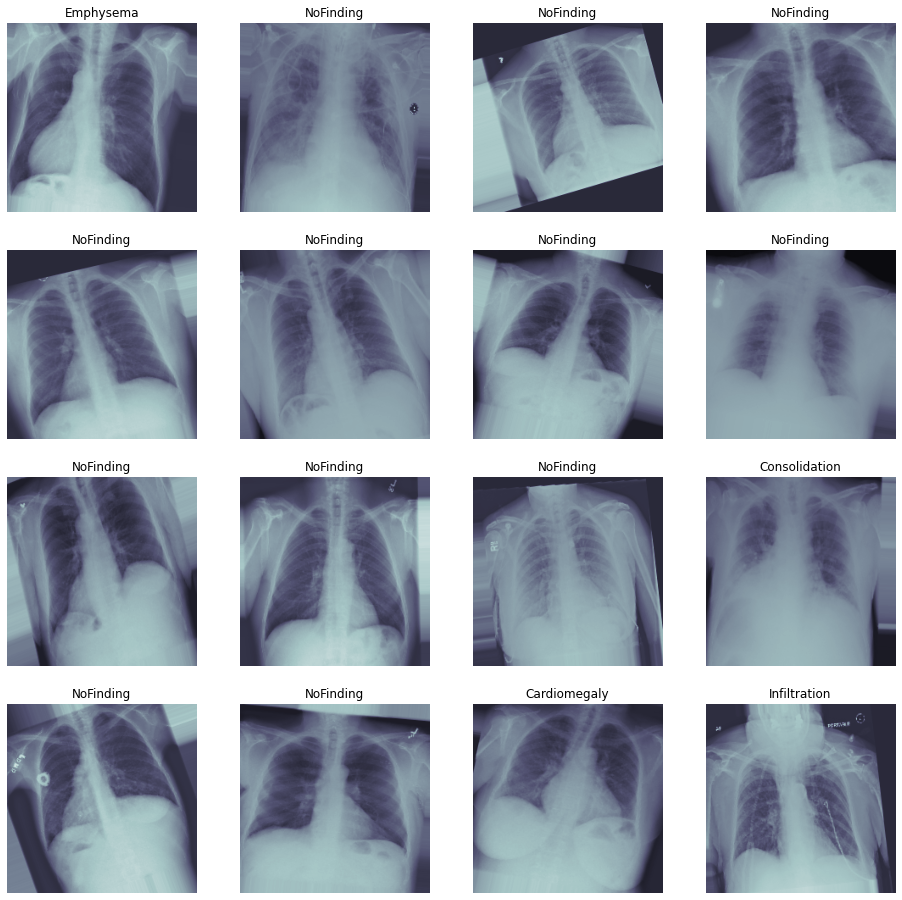

In [13]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

---

## Experiment 1: Classification using all data

### ResNetV250

ResNet50V2
learning rate 0.01
Epoch 1/20
71/71 [==============================] - 71s 970ms/step - loss: 2.1770 - accuracy: 0.4762 - val_loss: 1.6243 - val_accuracy: 0.6633
Epoch 2/20
71/71 [==============================] - 68s 960ms/step - loss: 1.5499 - accuracy: 0.6360 - val_loss: 1.3969 - val_accuracy: 0.6545
Epoch 3/20
71/71 [==============================] - 68s 963ms/step - loss: 1.4013 - accuracy: 0.6686 - val_loss: 1.3521 - val_accuracy: 0.6725
Epoch 4/20
71/71 [==============================] - 68s 966ms/step - loss: 1.4284 - accuracy: 0.6558 - val_loss: 1.3573 - val_accuracy: 0.6624
Epoch 5/20
71/71 [==============================] - 68s 970ms/step - loss: 1.4539 - accuracy: 0.6514 - val_loss: 1.3999 - val_accuracy: 0.6554
Epoch 6/20
71/71 [==============================] - 68s 966ms/step - loss: 1.3879 - accuracy: 0.6585 - val_loss: 1.3395 - val_accuracy: 0.6659
Epoch 7/20
71/71 [==============================] - 68s 968ms/step - loss: 1.3855 - accuracy: 0.6629 - val_loss:

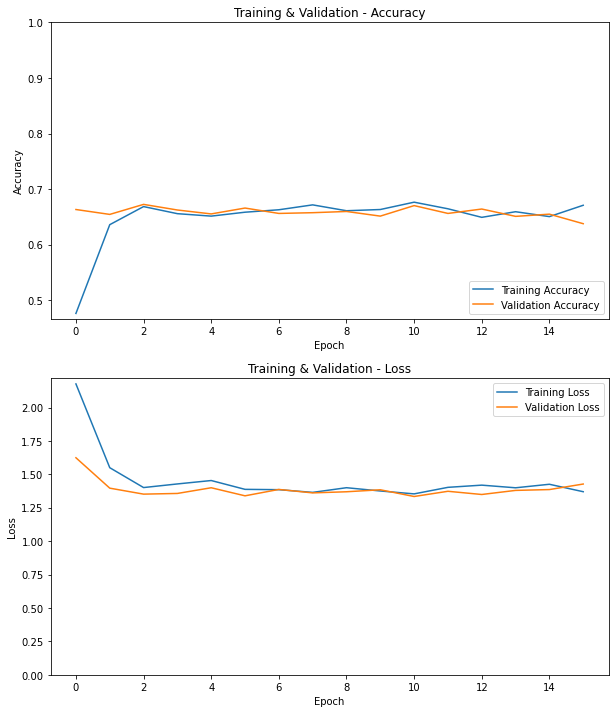





Fine-Tuned ResNet50V2 Training and Validation: 
Epoch 1/20
71/71 [==============================] - 70s 968ms/step - loss: 1.4338 - accuracy: 0.6470 - val_loss: 1.3767 - val_accuracy: 0.6651
Epoch 2/20
71/71 [==============================] - 68s 961ms/step - loss: 1.3975 - accuracy: 0.6655 - val_loss: 1.3703 - val_accuracy: 0.6496
Epoch 3/20
71/71 [==============================] - 67s 954ms/step - loss: 1.3142 - accuracy: 0.6800 - val_loss: 1.3418 - val_accuracy: 0.6633
Epoch 4/20
71/71 [==============================] - 67s 955ms/step - loss: 1.3917 - accuracy: 0.6571 - val_loss: 1.3754 - val_accuracy: 0.6514
Epoch 5/20
71/71 [==============================] - 67s 948ms/step - loss: 1.3972 - accuracy: 0.6602 - val_loss: 1.3532 - val_accuracy: 0.6593
Epoch 6/20
71/71 [==============================] - 67s 947ms/step - loss: 1.4074 - accuracy: 0.6479 - val_loss: 1.4104 - val_accuracy: 0.6417
Epoch 7/20
71/71 [==============================] - 67s 954ms/step - loss: 1.3809 - accura

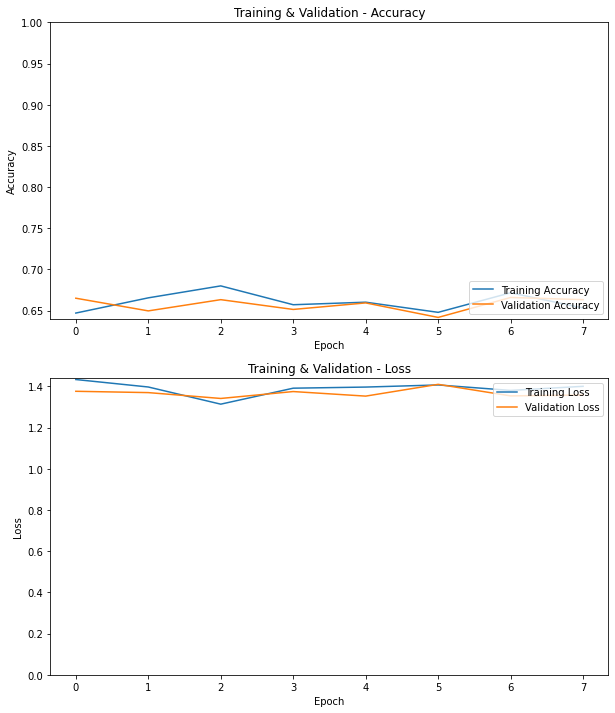

INFO:tensorflow:Assets written to: models/ResNet50V2exp1/assets


In [14]:
model_name = PRETRAINED_MODELS[0]
model = train_and_validate_model(model_name = model_name, 
                                 train_generator=train_generator, 
                                 valid_generator=valid_generator)
# for now saving resnetv2 as best model
model.save('models/'+ model_name + 'exp1')

### MobileNetV2

In [10]:
# model_name = PRETRAINED_MODELS[1]
# model = train_and_validate_model(model_name = model_name, train_generator=train_generator, valid_generator=valid_generator)
# # for now saving resnetv2 as best model
# model.save('models/'+ model_name + 'exp1')

### VGG16

In [11]:
# model_name = PRETRAINED_MODELS[2]
# model = train_and_validate_model(model_name = model_name, train_generator=train_generator, valid_generator=valid_generator)
# # for now saving resnetv2 as best model
# model.save('models/'+ model_name + 'exp1')

---

## Experiment 2: Balance the dataset

In [12]:
nih_xrays_df = pd.read_csv('data/processed/prepared_data_entry_2017.csv')

In [13]:
def sample_with_weights(df, all_labels, num_samples: int = 40000):
    for lbl in all_labels: 
        df[lbl] = df['finding_label'].map(lambda find: 1 if lbl in find else 0)
    df['encoding'] = [[1 if l in lbl.split('|') else 0 for l in all_labels] for lbl in nih_xrays_df['finding_label']]

    class_count = {}
    for lbl in all_labels:
        class_count[lbl] = df[lbl].sum()

    classweight = {}
    for lbl in all_labels :
        classweight[lbl] = 1/class_count[lbl]

    classweight['NoFinding'] /= 2   #Extra penalising the none class 
    def apply_weights(row):
        weight = 0
        for lbl in all_labels: 
            if(row[lbl]==1):
                weight += classweight[lbl]
        return weight
    new_weights = df.apply(apply_weights, axis=1)
    sampled_data = df.sample(50000, weights = new_weights)

    
    nih_required_columns = {
            'patient_id',
            'image_name',
            'path',
            'finding_label'
        }

  
    sampled_data = sampled_data[nih_required_columns]

    
    group_shuffle_split = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)

    for train_idx, valid_idx in group_shuffle_split.split(sampled_data[:None],\
        groups=sampled_data[:None]['patient_id'].values):
        train_df = sampled_data.iloc[train_idx]
        valid_df = sampled_data.iloc[valid_idx]
        
    return train_df, valid_df

In [14]:
train_df, valid_df = sample_with_weights(nih_xrays_df,all_labels,num_samples=40000)
sampled_train_gen = train_model.get_image_data_generator(train_df,batch_size=BATCH_SIZE,image_size=IMAGE_SIZE,lables=all_labels,shuffle=True,seed=SEED)
sampled_valid_gen = train_model.get_image_data_generator(valid_df,batch_size=BATCH_SIZE,image_size=IMAGE_SIZE,lables=all_labels,shuffle=True,seed=SEED)

Found 23849 validated image filenames belonging to 15 classes.
Found 6047 validated image filenames belonging to 15 classes.


### ResNet50V2

ResNet50V2
learning rate 0.01
Epoch 1/20
23/23 [==============================] - 16s 646ms/step - loss: 49.5342 - accuracy: 0.1236 - val_loss: 2.6482 - val_accuracy: 0.3000
Epoch 2/20
23/23 [==============================] - 14s 606ms/step - loss: 2.8925 - accuracy: 0.2418 - val_loss: 2.5779 - val_accuracy: 0.2375
Epoch 3/20
23/23 [==============================] - 14s 602ms/step - loss: 2.5293 - accuracy: 0.2446 - val_loss: 2.5274 - val_accuracy: 0.1813
Epoch 4/20
23/23 [==============================] - 14s 602ms/step - loss: 2.6627 - accuracy: 0.2120 - val_loss: 2.4518 - val_accuracy: 0.2250
Epoch 5/20
23/23 [==============================] - 14s 608ms/step - loss: 2.4591 - accuracy: 0.2201 - val_loss: 2.4812 - val_accuracy: 0.2125
Epoch 6/20
23/23 [==============================] - 14s 614ms/step - loss: 2.3937 - accuracy: 0.2391 - val_loss: 2.4136 - val_accuracy: 0.1937
Epoch 7/20
23/23 [==============================] - 14s 608ms/step - loss: 2.4242 - accuracy: 0.2106 - val_loss

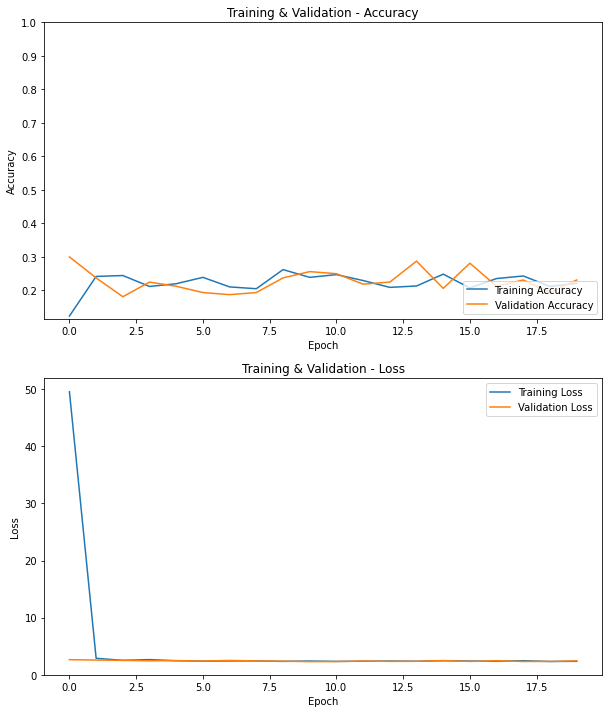





Fine-Tuned ResNet50V2 Training and Validation: 
Epoch 1/20
23/23 [==============================] - 16s 646ms/step - loss: 2.4160 - accuracy: 0.2038 - val_loss: 2.4550 - val_accuracy: 0.2000
Epoch 2/20
23/23 [==============================] - 14s 608ms/step - loss: 2.3837 - accuracy: 0.2378 - val_loss: 2.3145 - val_accuracy: 0.2438
Epoch 3/20
23/23 [==============================] - 14s 602ms/step - loss: 2.3959 - accuracy: 0.2323 - val_loss: 2.3684 - val_accuracy: 0.1875
Epoch 4/20
23/23 [==============================] - 14s 607ms/step - loss: 2.3551 - accuracy: 0.2459 - val_loss: 2.4427 - val_accuracy: 0.2188
Epoch 5/20
23/23 [==============================] - 14s 593ms/step - loss: 2.4080 - accuracy: 0.2132 - val_loss: 2.3885 - val_accuracy: 0.1813
Epoch 6/20
23/23 [==============================] - 14s 609ms/step - loss: 2.4010 - accuracy: 0.1997 - val_loss: 2.3960 - val_accuracy: 0.2375
Epoch 7/20
23/23 [==============================] - 14s 609ms/step - loss: 2.3642 - accura

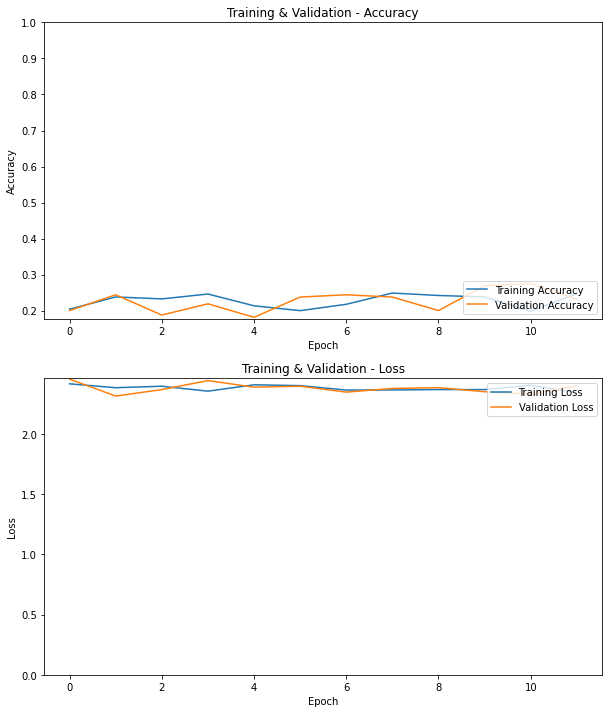

INFO:tensorflow:Assets written to: models/ResNet50V2exp2/assets


In [15]:
model_name = PRETRAINED_MODELS[0]
model = train_and_validate_model(model_name = model_name, train_generator=sampled_train_gen, valid_generator=sampled_valid_gen)
# for now saving resnetv2 as best model
model.save('models/'+ model_name + 'exp2')

### MobileNetV2

In [16]:
# model_name = PRETRAINED_MODELS[1]
# model = train_and_validate_model(model_name = model_name, train_generator=sampled_train_gen, valid_generator=sampled_valid_gen)
# # for now saving resnetv2 as best model
# model.save('models/'+ model_name + 'exp2')

### VGG16

In [17]:
# model_name = PRETRAINED_MODELS[2]
# model = train_and_validate_model(model_name = model_name, train_generator=sampled_train_gen, valid_generator=sampled_valid_gen)
# # for now saving resnetv2 as best model
# model.save('models/'+ model_name + 'exp2')

---

### Experiment 3: Sub Sampling Classes

In [18]:
sub_samples = ['Cardiomegaly','Effusion','Emphysema', 'Fibrosis', 'Infiltration', 'Pneumonia', 'Pneumothorax','Pleural_Thickening']

In [19]:
sub_nih_xrays_train_df  = nih_xrays_train_df [nih_xrays_train_df['finding_label'].isin(sub_samples)]
sub_nih_xrays_valid_df = nih_xrays_valid_df[nih_xrays_valid_df['finding_label'].isin(sub_samples)]
sub_sampled_train_gen = train_model.get_image_data_generator(sub_nih_xrays_train_df,batch_size=BATCH_SIZE,image_size=IMAGE_SIZE,lables=sub_samples,shuffle=True,seed=SEED)
sub_sampled_valid_gen = train_model.get_image_data_generator(sub_nih_xrays_valid_df,batch_size=BATCH_SIZE,image_size=IMAGE_SIZE,lables=sub_samples,shuffle=True,seed=SEED)

Found 15794 validated image filenames belonging to 8 classes.
Found 4060 validated image filenames belonging to 8 classes.


### ResNet50V2

ResNet50V2
learning rate 0.01
Epoch 1/20
15/15 [==============================] - 12s 680ms/step - loss: 106.6561 - accuracy: 0.2188 - val_loss: 2.3931 - val_accuracy: 0.3229
Epoch 2/20
15/15 [==============================] - 9s 615ms/step - loss: 7.3487 - accuracy: 0.3292 - val_loss: 1.9371 - val_accuracy: 0.5000
Epoch 3/20
15/15 [==============================] - 9s 614ms/step - loss: 2.4784 - accuracy: 0.5000 - val_loss: 1.8620 - val_accuracy: 0.4479
Epoch 4/20
15/15 [==============================] - 9s 610ms/step - loss: 1.8703 - accuracy: 0.4771 - val_loss: 1.7587 - val_accuracy: 0.4896
Epoch 5/20
15/15 [==============================] - 9s 611ms/step - loss: 1.8539 - accuracy: 0.4729 - val_loss: 1.7342 - val_accuracy: 0.4896
Epoch 6/20
15/15 [==============================] - 9s 608ms/step - loss: 1.6988 - accuracy: 0.4958 - val_loss: 1.7196 - val_accuracy: 0.4271
Epoch 7/20
15/15 [==============================] - 9s 621ms/step - loss: 1.6357 - accuracy: 0.4958 - val_loss: 1.6

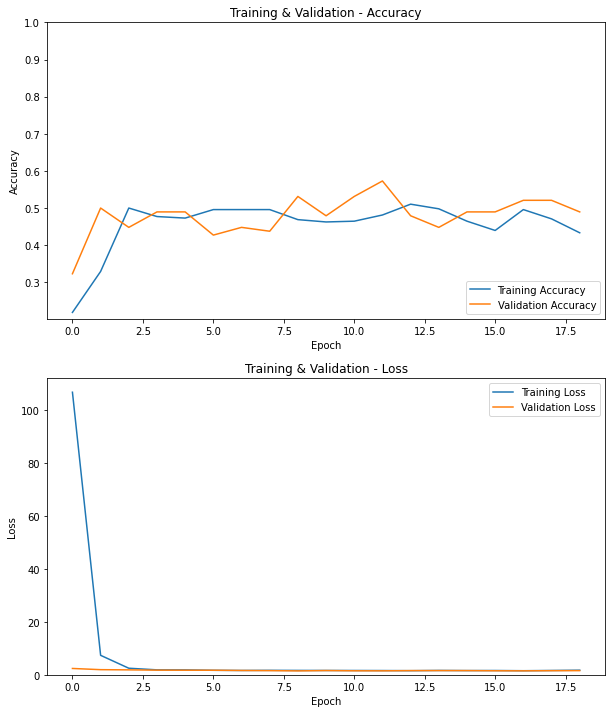





Fine-Tuned ResNet50V2 Training and Validation: 
Epoch 1/20
15/15 [==============================] - 11s 676ms/step - loss: 1.6208 - accuracy: 0.4812 - val_loss: 1.5056 - val_accuracy: 0.5208
Epoch 2/20
15/15 [==============================] - 9s 614ms/step - loss: 1.6672 - accuracy: 0.4646 - val_loss: 1.4578 - val_accuracy: 0.5625
Epoch 3/20
15/15 [==============================] - 9s 611ms/step - loss: 1.6334 - accuracy: 0.4688 - val_loss: 1.6032 - val_accuracy: 0.4896
Epoch 4/20
15/15 [==============================] - 9s 611ms/step - loss: 1.5664 - accuracy: 0.5125 - val_loss: 1.6362 - val_accuracy: 0.4375
Epoch 5/20
15/15 [==============================] - 9s 610ms/step - loss: 1.6031 - accuracy: 0.4750 - val_loss: 1.4477 - val_accuracy: 0.5833
Epoch 6/20
15/15 [==============================] - 9s 609ms/step - loss: 1.6448 - accuracy: 0.4750 - val_loss: 1.4354 - val_accuracy: 0.5417
Epoch 7/20
15/15 [==============================] - 9s 612ms/step - loss: 1.6195 - accuracy: 0.

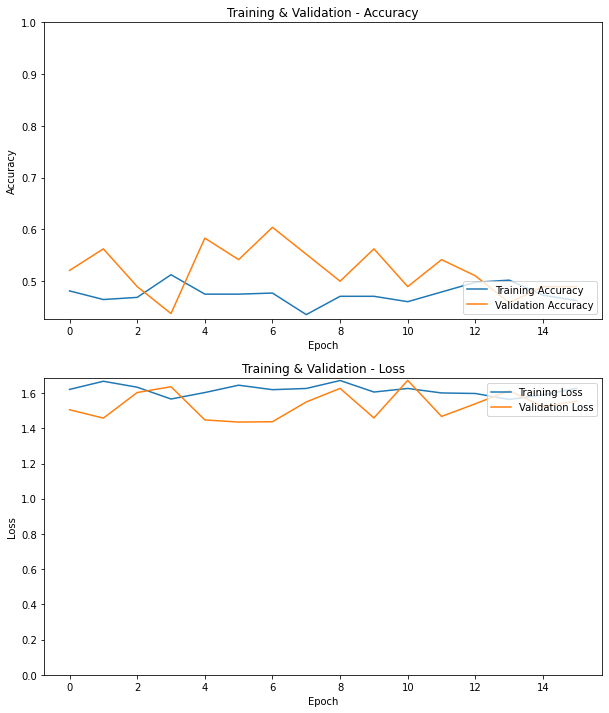

INFO:tensorflow:Assets written to: models/ResNet50V2exp3/assets


In [20]:
model_name = PRETRAINED_MODELS[0]
model = train_and_validate_model(model_name = model_name, train_generator=sub_sampled_train_gen, valid_generator=sub_sampled_valid_gen, num_classes=len(sub_samples))
# for now saving resnetv2 as best model
model.save('models/'+ model_name + 'exp3')

## MobileNETV2

In [21]:
# model_name = PRETRAINED_MODELS[1]
# model = train_and_validate_model(model_name = model_name, train_generator=sub_sampled_train_gen, valid_generator=sub_sampled_valid_gen, num_classes=len(sub_samples))
# # for now saving resnetv2 as best model
# model.save('models/'+ model_name + 'exp3')

## VGG16

In [22]:
# model_name = PRETRAINED_MODELS[2]
# model = train_and_validate_model(model_name = model_name, train_generator=sub_sampled_train_gen, valid_generator=sub_sampled_valid_gen,num_classes=len(sub_samples))
# # for now saving resnetv2 as best model
# model.save('models/'+ model_name + 'exp3')

---

### Experiment 4: Randoming reducing multiple lables to a single label for an image where multiple lables exist

In [23]:
import random
reduced_nih_xrays_train_df = nih_xrays_train_df
reduced_nih_xrays_valid_df = nih_xrays_valid_df
reduced_nih_xrays_train_df['finding_label'] = reduced_nih_xrays_train_df['finding_label'].map( lambda x : random.choice(x.split('|')) )
reduced_nih_xrays_valid_df['finding_label'] = reduced_nih_xrays_valid_df['finding_label'].map( lambda x : random.choice(x.split('|')) )
reduced_sampled_train_gen = train_model.get_image_data_generator(reduced_nih_xrays_train_df,batch_size=BATCH_SIZE,image_size=IMAGE_SIZE,lables=all_labels,shuffle=True,seed=SEED)
reduced_sampled_valid_gen = train_model.get_image_data_generator(reduced_nih_xrays_valid_df,batch_size=BATCH_SIZE,image_size=IMAGE_SIZE,lables=all_labels,shuffle=True,seed=SEED)

Found 89859 validated image filenames belonging to 15 classes.
Found 22245 validated image filenames belonging to 15 classes.


### ResNet50V2

ResNet50V2
learning rate 0.01
Epoch 1/20
87/87 [==============================] - 54s 606ms/step - loss: 15.9137 - accuracy: 0.4662 - val_loss: 2.1546 - val_accuracy: 0.4911
Epoch 2/20
87/87 [==============================] - 52s 598ms/step - loss: 2.0182 - accuracy: 0.5363 - val_loss: 1.7986 - val_accuracy: 0.5595
Epoch 3/20
87/87 [==============================] - 52s 598ms/step - loss: 1.8687 - accuracy: 0.5205 - val_loss: 1.7132 - val_accuracy: 0.5551
Epoch 4/20
87/87 [==============================] - 52s 598ms/step - loss: 1.8035 - accuracy: 0.5269 - val_loss: 1.7631 - val_accuracy: 0.5223
Epoch 5/20
87/87 [==============================] - 52s 601ms/step - loss: 1.7497 - accuracy: 0.5399 - val_loss: 1.7592 - val_accuracy: 0.5193
Epoch 6/20
87/87 [==============================] - 52s 596ms/step - loss: 1.7299 - accuracy: 0.5388 - val_loss: 1.6663 - val_accuracy: 0.5610
Epoch 7/20
87/87 [==============================] - 52s 597ms/step - loss: 1.7461 - accuracy: 0.5348 - val_loss

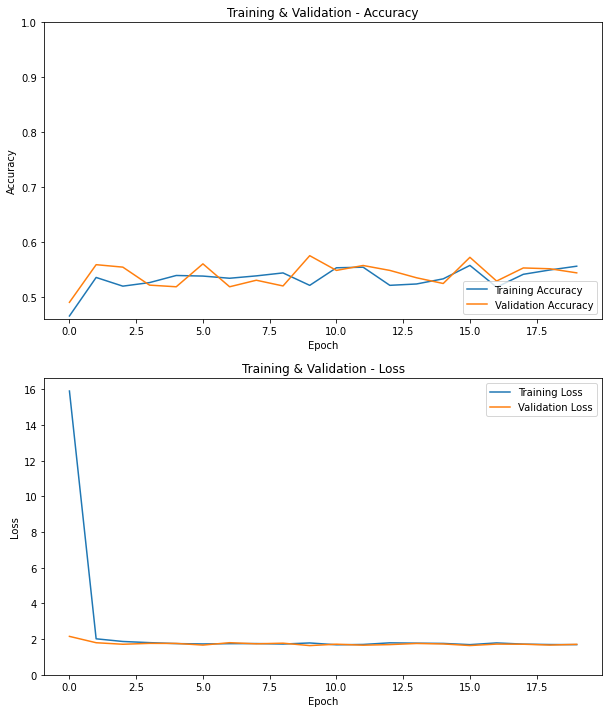





Fine-Tuned ResNet50V2 Training and Validation: 
Epoch 1/20
87/87 [==============================] - 54s 607ms/step - loss: 1.7497 - accuracy: 0.5295 - val_loss: 1.6998 - val_accuracy: 0.5446
Epoch 2/20
87/87 [==============================] - 52s 600ms/step - loss: 1.7692 - accuracy: 0.5244 - val_loss: 1.6902 - val_accuracy: 0.5565
Epoch 3/20
87/87 [==============================] - 52s 599ms/step - loss: 1.7850 - accuracy: 0.5223 - val_loss: 1.7056 - val_accuracy: 0.5446
Epoch 4/20
87/87 [==============================] - 52s 599ms/step - loss: 1.7159 - accuracy: 0.5449 - val_loss: 1.6994 - val_accuracy: 0.5625
Epoch 5/20
87/87 [==============================] - 52s 594ms/step - loss: 1.7624 - accuracy: 0.5374 - val_loss: 1.6841 - val_accuracy: 0.5551
Epoch 6/20
87/87 [==============================] - 52s 595ms/step - loss: 1.7363 - accuracy: 0.5352 - val_loss: 1.7429 - val_accuracy: 0.5238
Epoch 7/20
87/87 [==============================] - 52s 598ms/step - loss: 1.7324 - accura

In [24]:
model_name = PRETRAINED_MODELS[0]
model = train_and_validate_model(model_name = model_name, train_generator=reduced_sampled_train_gen, valid_generator=reduced_sampled_valid_gen)
# for now saving resnetv2 as best model
model.save('models/'+ model_name + 'exp4')

## MobileNETV2

In [ ]:
# model_name = PRETRAINED_MODELS[1]
# model = train_and_validate_model(model_name = model_name, train_generator=reduced_sampled_train_gen, valid_generator=reduced_sampled_valid_gen)
# # for now saving resnetv2 as best model
# model.save('models/'+ model_name + 'exp4')

Error: Session cannot generate requests

## VGG16

In [ ]:
# model_name = PRETRAINED_MODELS[2]
# model = train_and_validate_model(model_name = model_name, train_generator=reduced_sampled_train_gen, valid_generator=reduced_sampled_valid_gen)
# # for now saving resnetv2 as best model
# model.save('models/'+ model_name + 'exp4')

__Run this cell from command prompt__  
  
  
jupyter-nbconvert --to pdf COVID-19-Image-Classification-phase1.ipynb

### Clean UP 
run this cell after completing execution of the notebook

In [ ]:
# clear gpu memory
from numba import cuda 
device = cuda.get_current_device()
device.reset()